# Loi d'Amdahl – Analyse empirique

Notebook basé sur `benchmarks/results.jsonl`.


In [178]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.style.use('seaborn-v0_8-colorblind')

JSONL_PATH = Path('benchmarks/results.jsonl')
if not JSONL_PATH.exists():
    raise FileNotFoundError(f'Fichier JSONL introuvable: {JSONL_PATH}')

records = []
with JSONL_PATH.open('r', encoding='utf-8') as fh:
    for line in fh:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
        except json.JSONDecodeError:
            continue
        records.append(rec)

if not records:
    raise ValueError('Le JSONL ne contient aucun enregistrement exploitable.')

df = pd.DataFrame(records)
for col in ['workers', 'splits', 'duration_seconds', 'total_words', 'unique_words']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['workers', 'splits', 'duration_seconds'])
if df.empty:
    raise ValueError('Toutes les lignes ont été filtrées (valeurs manquantes).')

df['workers'] = df['workers'].astype(int)
df['splits'] = df['splits'].astype(int)


In [179]:
def flatten_lang(entry):
    if isinstance(entry, list):
        out = []
        for item in entry:
            if isinstance(item, dict) and 'lang' in item and 'count' in item:
                try:
                    out.append((item['lang'], int(item['count'])))
                except (TypeError, ValueError):
                    continue
        return out
    return []

df['language_pairs'] = df.get('languages', []).apply(flatten_lang)
df.head()


,timestamp,workers,splits,duration_seconds,total_words,unique_words,top_words,per_worker,languages,output_dir,language_pairs
0,2025-11-19T01:03:59.384922+00:00,1,10,1104.948403,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
1,2025-11-19T01:12:44.852307+00:00,2,10,440.683032,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
2,2025-11-19T01:18:52.035809+00:00,3,10,299.764858,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
3,2025-11-19T01:23:50.988805+00:00,4,10,219.566310,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
4,2025-11-19T01:29:34.146563+00:00,5,10,241.293791,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."


In [180]:
if not {'workers','splits','duration_seconds'}.issubset(df.columns):
    raise KeyError('Colonnes workers/splits/duration_seconds manquantes.')

# Agrégation des runs par (splits, workers)
if 'timestamp' in df.columns:
    grouped = (
        df.groupby(['splits','workers'], as_index=False)
          .agg(
              elapsed_seconds=('duration_seconds','mean'),
              elapsed_std=('duration_seconds','std'),
              run_count=('timestamp','count'),
          )
    )
else:
    grouped = (
        df.groupby(['splits','workers'], as_index=False)
          .agg(
              elapsed_seconds=('duration_seconds','mean'),
              elapsed_std=('duration_seconds','std'),
              run_count=('duration_seconds','count'),
          )
    )

grouped['elapsed_std'] = grouped['elapsed_std'].fillna(0.0)


def amdahl_speedup(p, s):
    """Speedup Amdahl pour une fraction parallélisable p et s workers."""
    return 1.0 / (1.0 - p + p / s)


def process_group(data):
    data = data.sort_values('workers').reset_index(drop=True)
    splits_val = int(data['splits'].iloc[0])
    # Temps pour workers == splits, utilisé comme référence par worker
    ref = data.loc[data['workers'] == splits_val, 'elapsed_seconds']
    if not ref.empty and splits_val > 0:
        T_splits = ref.iloc[0]
        T_ref = T_splits / splits_val
    else:
        # repli : temps du plus petit nombre de workers, ramené à 1 worker
        base = data.iloc[0]
        T_ref = float(base['elapsed_seconds']) / float(base['workers'])

    # Speedup observe: (N * T_ref) / T(N)
    data['speedup_observe'] = 1 + (data['workers'] * T_ref) / data['elapsed_seconds']

    s = data['workers'].to_numpy(dtype=float)
    obs = data['speedup_observe'].to_numpy(dtype=float)
    grid = np.linspace(0.0, 0.99, 2000)
    errors = [np.sum((amdahl_speedup(p, s) - obs) ** 2) for p in grid]
    p_parallel = float(grid[int(np.argmin(errors))])
    data['speedup_pred_amdahl'] = amdahl_speedup(p_parallel, s)
    data['p_parallel_estimate'] = p_parallel
    print(f"Splits={splits_val}: p_parallel_estimate={p_parallel:.4f} (f = {1-p_parallel:.4f})")
    return data

summary = grouped.groupby('splits', group_keys=False, sort=True).apply(process_group)
summary = summary.reset_index(drop=True)
summary.head()


Splits=5: p_parallel_estimate=0.6834 (f = 0.3166)
Splits=10: p_parallel_estimate=0.5750 (f = 0.4250)
Splits=15: p_parallel_estimate=0.3818 (f = 0.6182)
Splits=20: p_parallel_estimate=0.4135 (f = 0.5865)
Splits=25: p_parallel_estimate=0.3699 (f = 0.6301)


/tmp/ipykernel_7724/102951543.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = grouped.groupby('splits', group_keys=False, sort=True).apply(process_group)


,splits,workers,elapsed_seconds,elapsed_std,run_count,speedup_observe,speedup_pred_amdahl,p_parallel_estimate
0,5,1,549.217798,0.0,1,1.028062,1.000000,0.683442
1,5,2,234.811081,0.0,1,1.131272,1.519112,0.683442
2,5,3,147.388421,0.0,1,1.313703,1.836978,0.683442
3,5,4,136.433653,0.0,1,1.451856,2.051624,0.683442
4,5,5,77.060407,0.0,1,2.000000,2.206304,0.683442


## Visualisations 2D par splits


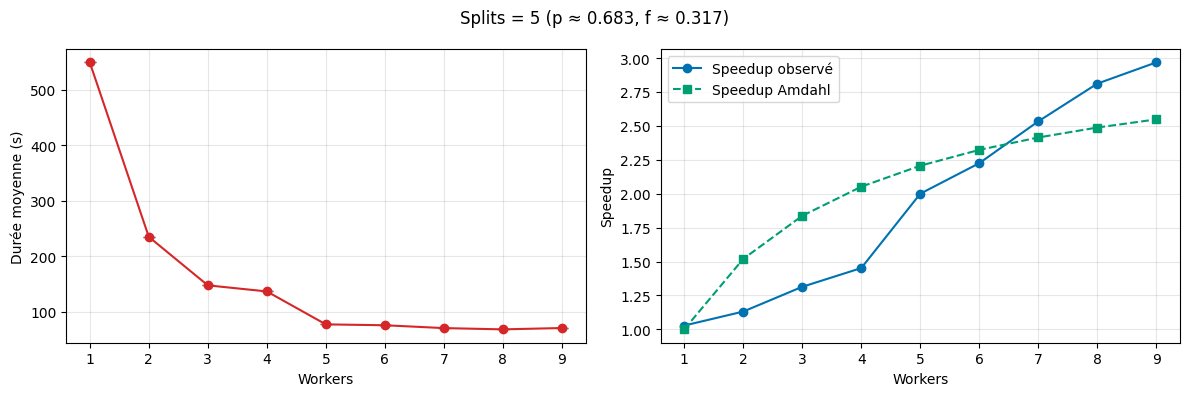

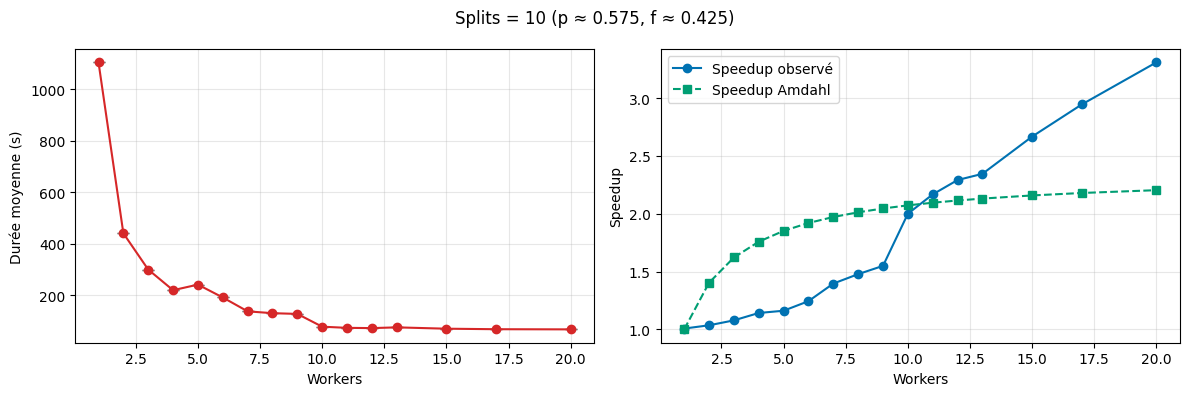

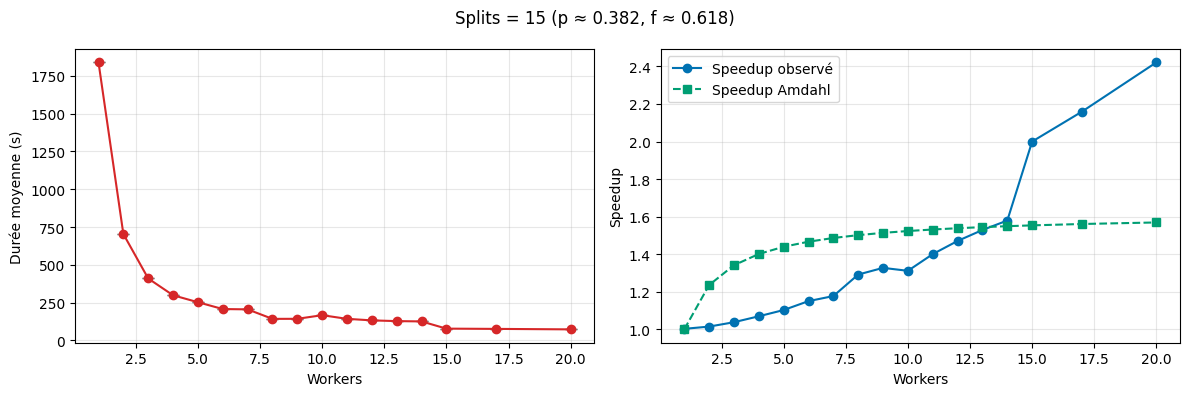

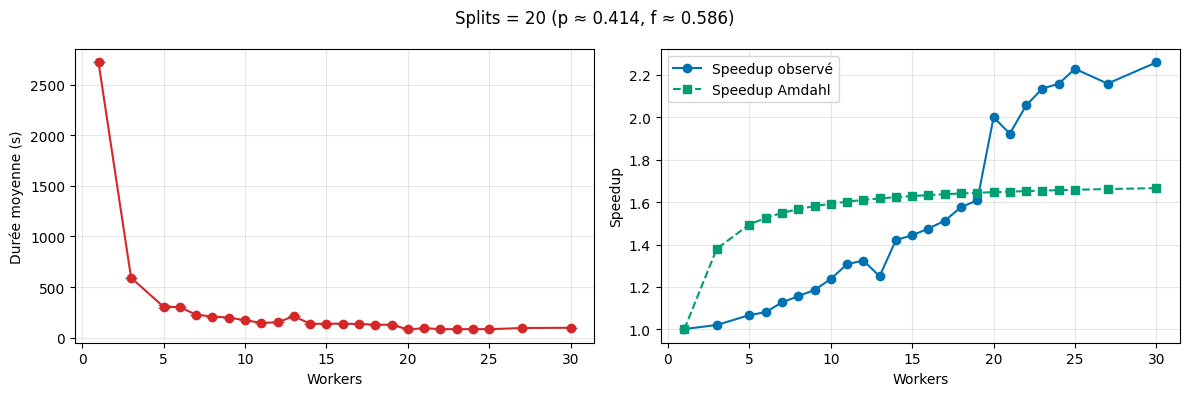

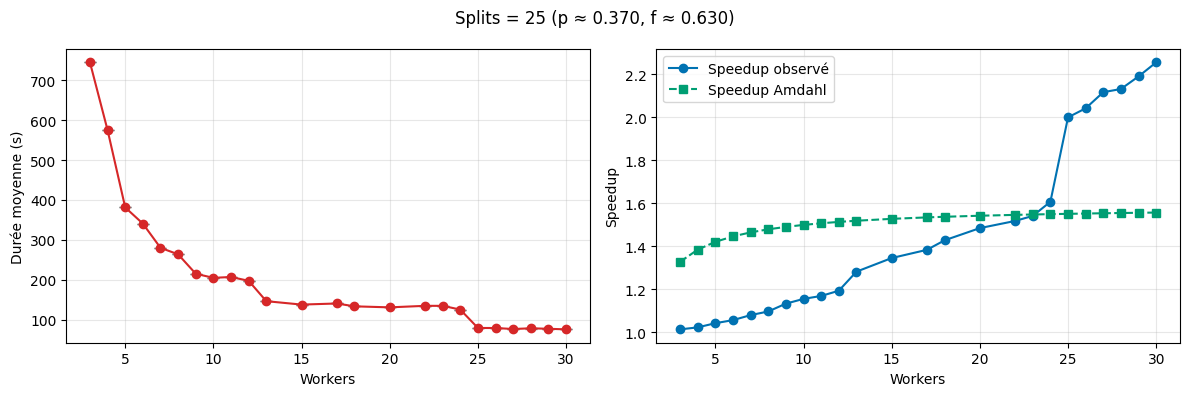

In [181]:
for splits_val, subset in summary.groupby('splits'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    p = subset['p_parallel_estimate'].iloc[0]
    f = 1.0 - p
    fig.suptitle(f"Splits = {splits_val} (p ≈ {p:.3f}, f ≈ {f:.3f})")

    axes[0].errorbar(
        subset['workers'],
        subset['elapsed_seconds'],
        yerr=subset['elapsed_std'],
        fmt='o-',
        color='tab:red',
        ecolor='gray',
        capsize=4,
    )
    axes[0].set_xlabel('Workers')
    axes[0].set_ylabel('Durée moyenne (s)')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(subset['workers'], subset['speedup_observe'], 'o-', label='Speedup observé')
    axes[1].plot(subset['workers'], subset['speedup_pred_amdahl'], 's--', label='Speedup Amdahl')
    axes[1].set_xlabel('Workers')
    axes[1].set_ylabel('Speedup')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Hyperplan 3D


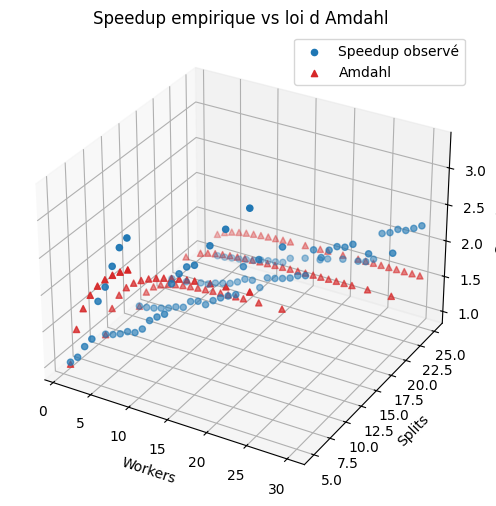

In [182]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(summary['workers'], summary['splits'], summary['speedup_observe'], c='tab:blue', label='Speedup observé')
ax.scatter(summary['workers'], summary['splits'], summary['speedup_pred_amdahl'], marker='^', color='tab:red', label='Amdahl')
ax.set_xlabel('Workers')
ax.set_ylabel('Splits')
ax.set_zlabel('Speedup')
ax.legend()
plt.title('Speedup empirique vs loi d Amdahl')
plt.show()


## Langues par splits


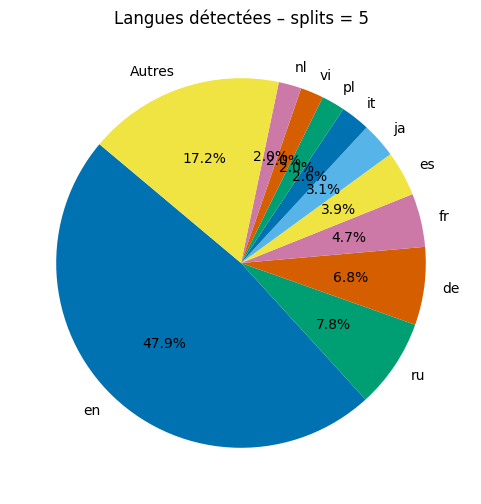

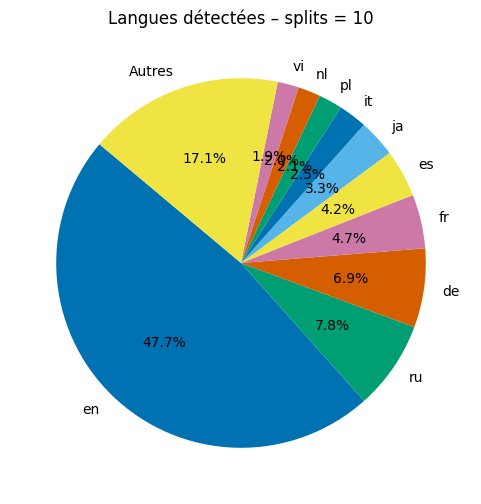

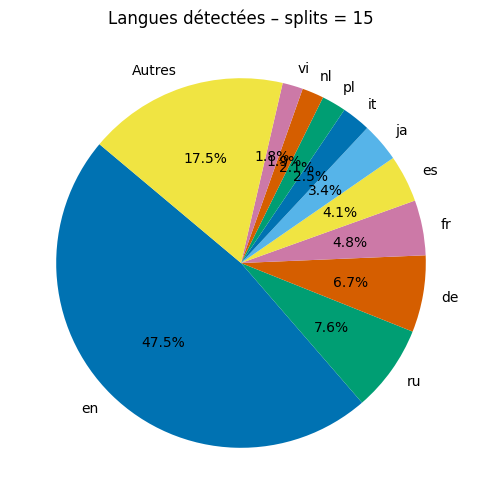

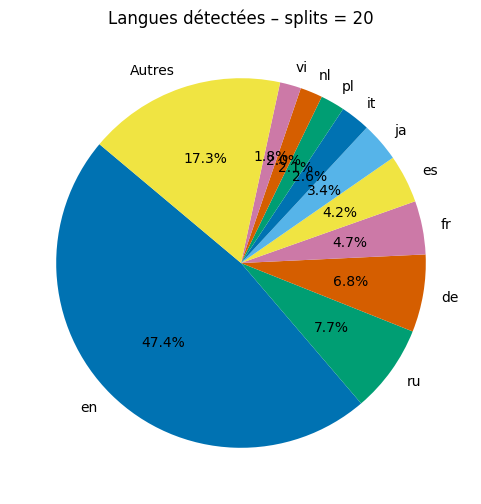

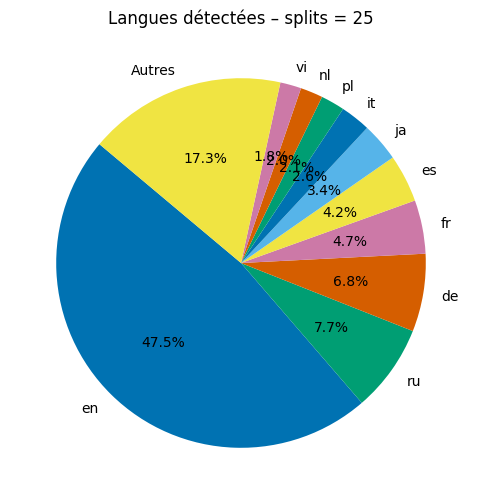

In [183]:
lang_df = df[['splits', 'language_pairs']].explode('language_pairs').dropna(subset=['language_pairs'])
if not lang_df.empty:
    lang_df[['lang','lang_count']] = pd.DataFrame(lang_df['language_pairs'].tolist(), index=lang_df.index)
    lang_df['lang_count'] = pd.to_numeric(lang_df['lang_count'], errors='coerce').fillna(0).astype(int)
    for splits_val, chunk in lang_df.groupby('splits'):
        totals = chunk.groupby('lang')['lang_count'].sum().sort_values(ascending=False)
        top = totals.head(10)
        others = totals.iloc[10:].sum()
        labels = list(top.index)
        values = list(top.values)
        if others > 0:
            labels.append('Autres')
            values.append(others)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Langues détectées – splits = {splits_val}')
        plt.show()
else:
    print('Aucune information sur les langues.')
